<a href="https://colab.research.google.com/github/Siddhartha-Patolia/my_projects/blob/main/HMM_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pdh
%pip install yfinance
import yfinance as yf
import datetime
import time
import requests
import io

In [ ]:
data = yf.download("GOOG", start="2000-01-01", end="2021-08-01")

[*********************100%%**********************]  1 of 1 completed


In [ ]:
train_size = int(0.8*data.shape[0])
print(train_size)

3413


In [ ]:
train_data = data.iloc[0:train_size]
test_data = data.iloc[train_size+1:]

In [ ]:
test_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-03-13,58.500000,58.838001,56.666500,56.908501,56.908501,38144000
2018-03-14,57.260502,57.929501,57.071999,57.474499,57.474499,25828000
2018-03-15,57.498001,58.054001,56.727001,57.479000,57.479000,27908000
2018-03-16,57.707001,57.793999,56.598000,56.786499,56.786499,61840000
2018-03-19,56.000500,56.099499,54.450500,54.991001,54.991001,56118000
...,...,...,...,...,...,...
2021-07-26,138.250000,139.712997,137.651001,139.644501,139.644501,23052000
2021-07-27,140.011002,140.011002,135.100006,136.796494,136.796494,42164000
2021-07-28,138.561996,139.675995,136.350006,136.381500,136.381500,54688000


In [ ]:
def augment_features(dataframe):
    fracocp = (dataframe['Close']-dataframe['Open'])/dataframe['Open']
    frachp = (dataframe['High']-dataframe['Open'])/dataframe['Open']
    fraclp = (dataframe['Open']-dataframe['Low'])/dataframe['Open']
    new_dataframe = pdh.DataFrame({'delOpenClose': fracocp,
                                 'delHighOpen': frachp,
                                 'delLowOpen': fraclp})
    new_dataframe.set_index(dataframe.index)

    return new_dataframe

In [ ]:
def extract_features(dataframe):
    return np.column_stack((dataframe['delOpenClose'], dataframe['delHighOpen'], dataframe['delLowOpen']))

In [ ]:
features = extract_features(augment_features(train_data))

In [ ]:
!pip install hmmlearn
from hmmlearn.hmm import GaussianHMM


In [ ]:
model = GaussianHMM(n_components=10)
feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)
model.fit(features_train)

GaussianHMM(n_components=10)

In [ ]:
import itertools

test_augmented = augment_features(test_data)
fracocp = test_augmented['delOpenClose']
frachp = test_augmented['delHighOpen']
fraclp = test_augmented['delLowOpen']

sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), 50)
sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), 10)
sample_space_frachp = np.linspace(frachp.min(), frachp.max(), 10)

possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))   #cartesian product

In [ ]:
num_latent_days = 50
num_days_to_predict = 300
from tqdm import tqdm

predicted_close_prices = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

    outcome_scores = []
    for outcome in possible_outcomes:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))

    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
    predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████| 300/300 [09:49<00:00,  1.96s/it]


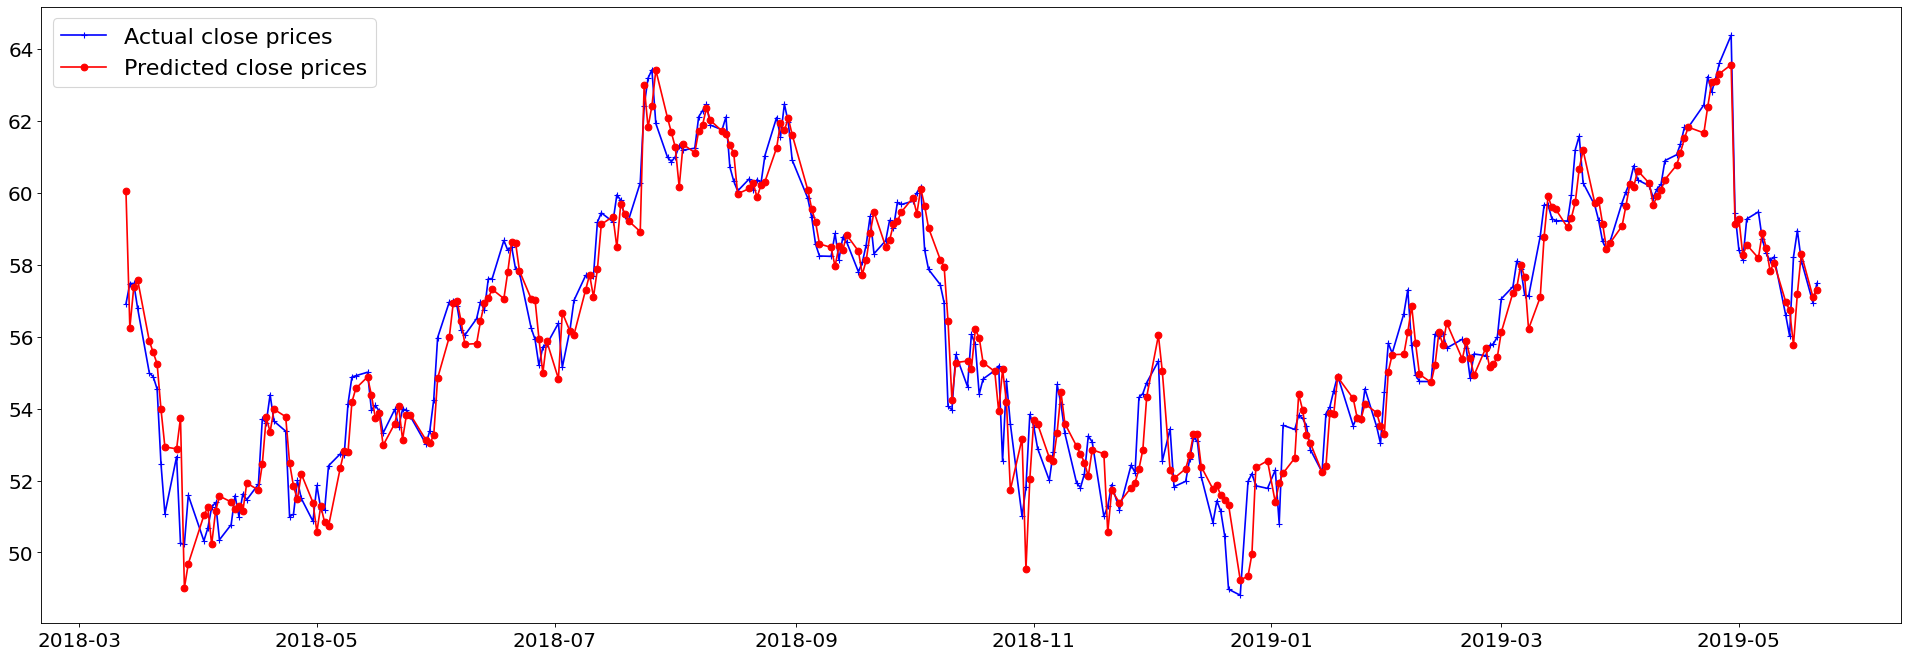

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

x_axis = np.array(test_data.index[0:num_days_to_predict], dtype='datetime64[ms]')
plt.plot(x_axis, test_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
plt.plot(x_axis, predicted_close_prices, 'ro-', label="Predicted close prices")
plt.legend(prop={'size': 20})
plt.show()

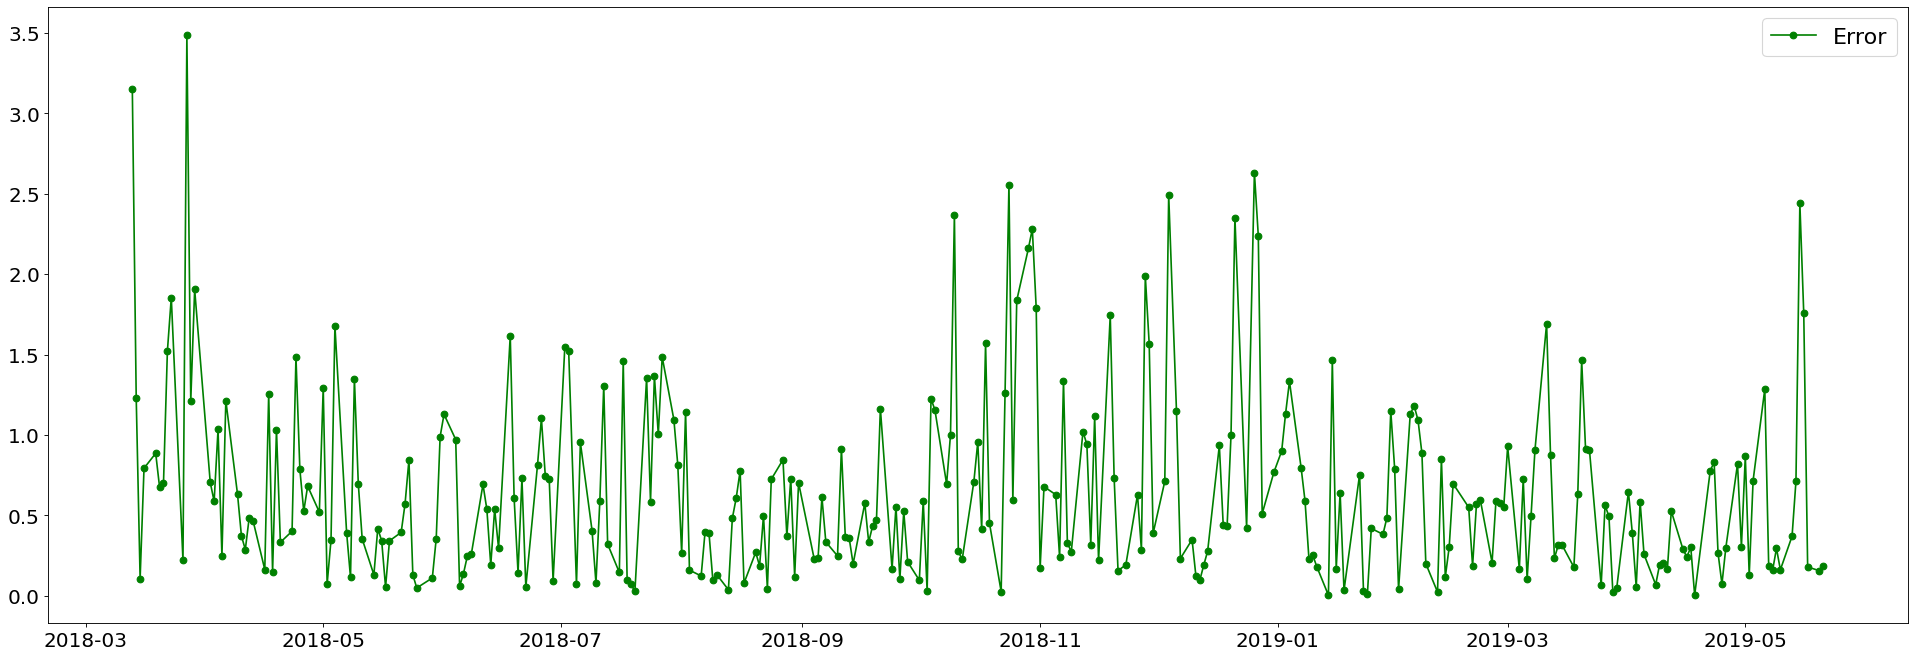

In [ ]:
ae = abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)

plt.figure(figsize=(30,10), dpi=80)

plt.plot(x_axis, ae, 'go-', label="Error")
plt.legend(prop={'size': 20})
plt.show()

In [ ]:
print("Max error observed = " + str(ae.max()))
print("Min error observed = " + str(ae.min()))
print("Mean error observed = " + str(ae.mean()))

Max error observed = 3.4849306248018266
Min error observed = 0.0038919173385849604
Mean error observed = 0.6499831771634437


Possible Hyperparameter Tuning:

In [ ]:
num_latent_days_values = [10, 20, 30, 40, 50, 60]
baseline_num_latent_days = 50
n_components_values = [4, 6, 8, 10, 12, 14]
baseline_n_componets = 10
num_steps_values = [10, 20, 40, 50]
baseline_num_steps = 50
num_days_to_predict = 100 # We don't need to predict as many days as before

Comparing across different values for num_components:

In [ ]:
mae_num_components = []
for num_component in n_components_values:
    model = GaussianHMM(n_components=num_component)
    model.fit(features_train)
    predicted_close_prices = []
    for i in tqdm(range(num_days_to_predict)):

        previous_data_start_index = max(0, i - baseline_num_latent_days)
        previous_data_end_index = max(0, i)

        previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))

        outcome_scores = []
        for outcome in possible_outcomes:

            total_data = np.row_stack((previous_data, outcome))
            outcome_scores.append(model.score(total_data))


        most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
        predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))
    mae_num_components.append((abs(test_data.iloc[0:num_days_to_predict]['Close'] - predicted_close_prices)).mean())

100%|██████████| 100/100 [03:29<00:00,  2.10s/it]


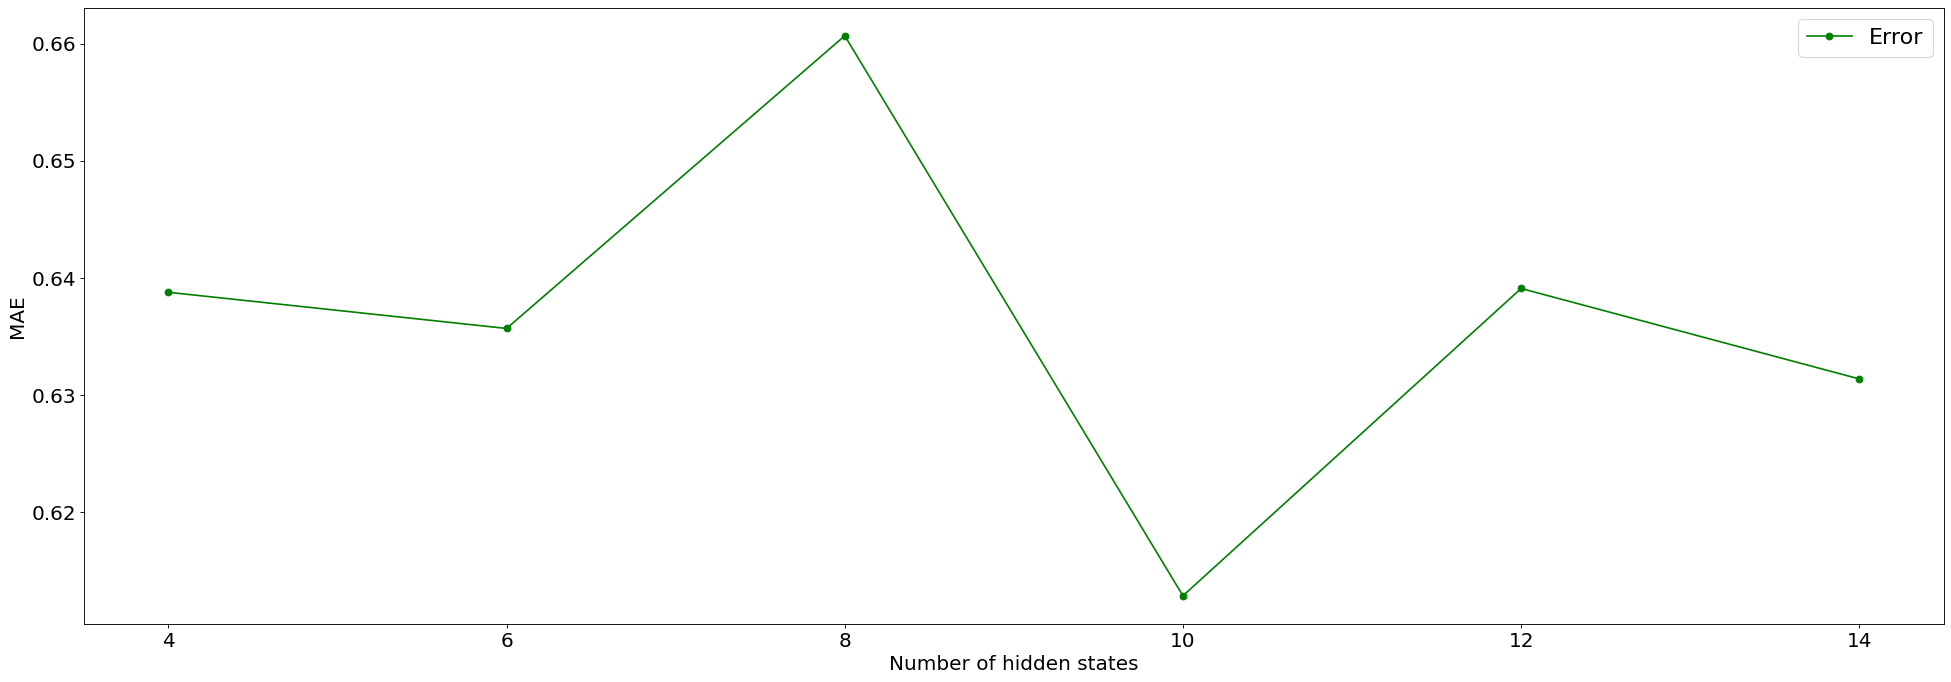

In [ ]:
plt.figure(figsize=(30,10), dpi=80)
plt.plot(n_components_values, mae_num_components, 'go-', label="Error")
plt.xlabel("Number of hidden states")
plt.ylabel("MAE")
plt.legend(prop={'size': 20})
plt.show()

Similarly other hyperparameters can also be tuned